# Basic regression: Predict fuel efficiency

This tutorial uses the classic [Auto MPG](https://) dataset and demonstrates how to build models to predict the fuel efficiency of the late-1970s and early 1980s automobiles. We provide the models with a description of many automobiles from that time period. This description includes attributes like cylinders, displacement, horsepower, and weight.

In [87]:
# Using seaborn for pairplot
!pip install -q seaborn

## Importing important Libraries

In [88]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Making NumPy printouts easier to read
np.set_printoptions(precision=3, suppress=True)

In [89]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf. __version__)

2.18.0


## The Auto MPG dataset
The dataset is available from the UCI Machine Learning Repository

## Downloading the data and importing using pandas

In [90]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names, na_values='?', comment='\t', sep=' ', skipinitialspace=True)


In [91]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


## Cleaning the Data

In [92]:
dataset.isna().sum()

,0
MPG,0
Cylinders,0
Displacement,0
Horsepower,6
Weight,0
Acceleration,0
Model Year,0
Origin,0


In [93]:
# Dropping these rows to keep the initial dataset simple
dataset = dataset.dropna()

"Origin" column is categorical, not numeric




In [94]:
# Setting one-hot encode for values in the column with pd.get_dummies
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [95]:
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,False,False,True
394,44.0,4,97.0,52.0,2130.0,24.6,82,True,False,False
395,32.0,4,135.0,84.0,2295.0,11.6,82,False,False,True
396,28.0,4,120.0,79.0,2625.0,18.6,82,False,False,True
397,31.0,4,119.0,82.0,2720.0,19.4,82,False,False,True


## Splitting the data into training and test sets

In [96]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

## Inspecting the data
The top row suggests that the fuel efficiency(MPG) is a function of all other parameters. The other rows indicate they are functions of each other

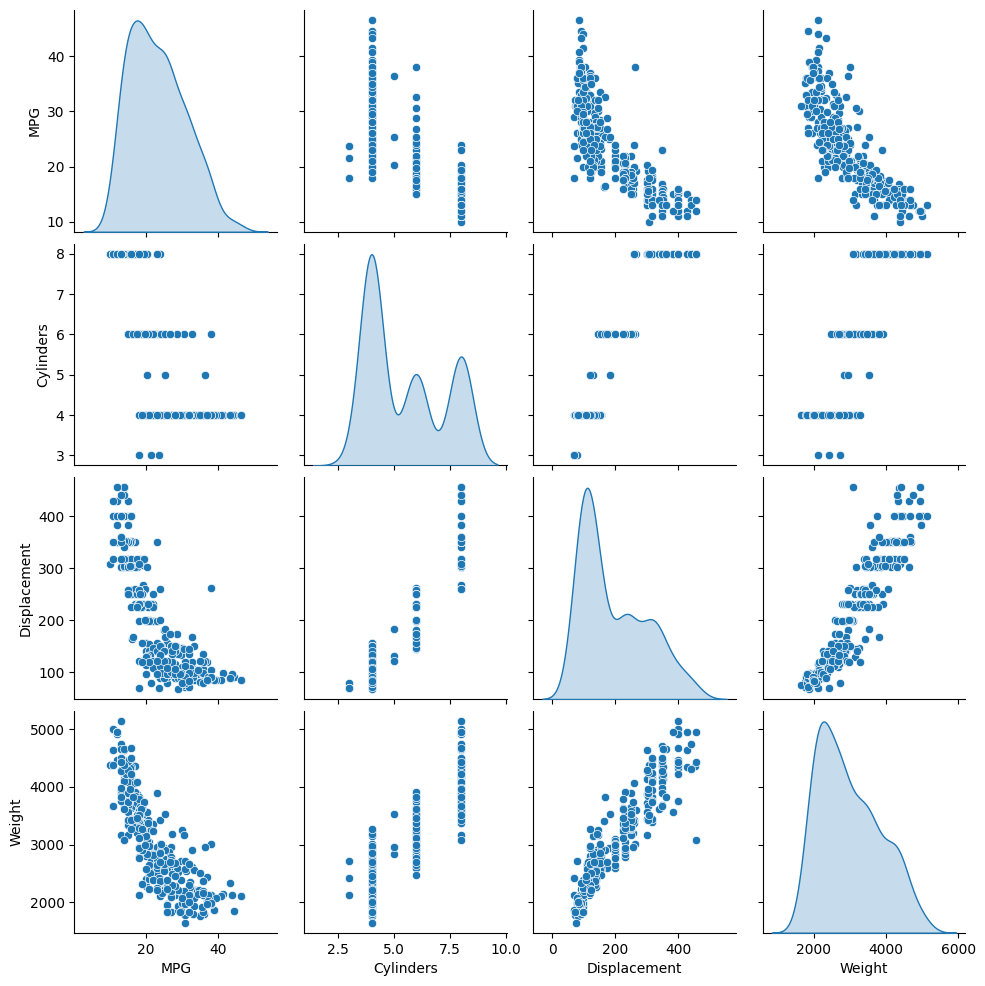

In [97]:
# reviewing the joint distribution of a few pairs of columns from the training set
sns.pairplot(train_dataset[['MPG','Cylinders', 'Displacement', 'Weight']], diag_kind='kde')

In [98]:
# Checking the overall statistics
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0


## Splitting features from labels

This labael will be used to train the model used to predict

In [99]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('MPG')
test_labels = test_features.pop('MPG')

## Normalization

In [100]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
MPG,23.310510,7.728652
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642


## The Normalization Layer

The [tf.keras.layers.Normalization](https://) is a clean and simple way to add feauture normalization into your model.

In [101]:
# Creating the normalization layer
normalizer = tf.keras.layers.Normalization(axis=-1)



# Fitting the state of the preprocessing layer to the data by calling [Normalization.adapt](https://)

In [102]:
normalizer.adapt(np.array(train_features))

In [103]:
# Calculating the mean and variance, and storing them in the layer
print(normalizer.mean.numpy())

[[   5.478  195.318  104.869 2990.252   15.559   75.898    0.178    0.197
     0.624]]


In [104]:
# When the layer is called, it returns the input data, with each feature independently normalized:
first = np.array(train_features[:1], dtype=np.float32)

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[   4.    90.    75.  2125.    14.5   74.     0.     0.     1. ]]

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


## Linear Regression

# Linear regression with one variable
Begin with a single-variable linear regression to predict **'MPG'** from **'Horsepower'**.

Training a model with [tf.keras](https://) typically starts by defining the model architecture. Use a [tf.keras.Sequential](https://) model, which represents a sequence of steps.

There are two steps in your single-variable linear regression model:

*   Normalize the **'Horsepower'**  
    input features using the **tf.keras.layers.Normalization** preprocessing layer.
*   Apply a linear transformation  *(y = mx + c)* to produce 1 output using a
    linear layer [tf.keras.layers.Dense](https://) .

The number of inputs can either be set by the **input_shape** argument, or automatically when the model is run for the first time.

First, create a NumPy array made of the **'Horsepower'** features. Then, instantiate the **tf.keras.layers.Normalization** and fit its state to the horsepower data:

In [105]:
horsepower = np.array(train_features['Horsepower'])

horsepower_normalizer = layers.Normalization(input_shape=[1,], axis=None)
horsepower_normalizer.adapt(horsepower)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Building the Keras Sequential model


In [106]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
  ])
horsepower_model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_5 (Normalization) │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5 (24.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 3 (16.00 B)

This model will predict **'MPG'** from **'Horsepower'**


In [107]:
# Running the untrained model for the first 10 'Horsepower' values
horsepower_model.predict(horsepower[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


array([[ 0.642],
       [ 0.363],
       [-1.185],
       [ 0.9  ],
       [ 0.814],
       [ 0.32 ],
       [ 0.965],
       [ 0.814],
       [ 0.212],
       [ 0.363]], dtype=float32)

## Configuring the model using the Keras [Model.compile](https://) method.

The most important arguments to compile are the **loss** and **optimizer**, since these define what will be optimized (**mean_absolute_error**) and how (using the [tf.keras.optimizers.Adam](https://))

In [108]:
horsepower_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.2),
    loss='mean_absolute_error'
)

Using Keras Model.fit to excute the training for 100 epochs

In [109]:
history = horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    epochs=100,
    # Suppressing the logging.
    verbose=0,
    # Calculating validation results 0n 205 of the training data
    validation_split = 0.2
  )

Visualizing the model's training progress using the stats stored in the **history** object

In [110]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,3.804348,4.178390,95
96,3.826820,4.138969,96
97,3.812315,4.199718,97
98,3.807832,4.210053,98
99,3.803744,4.181576,99


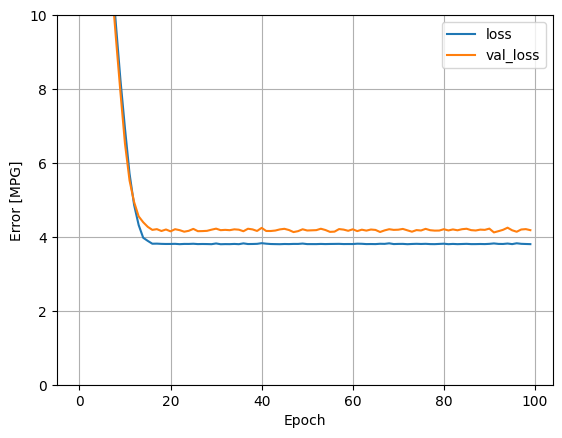

In [111]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0,10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

plot_loss(history)

Collecting the results on the test set for later:

In [112]:
test_results = {}

test_results['horsepower_model'] = horsepower_model.evaluate(
    test_features['Horsepower'],
    test_labels,
    verbose=0
)

# Since this is a single variable regression, it's easy to view the model's predictions as a function of the input
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


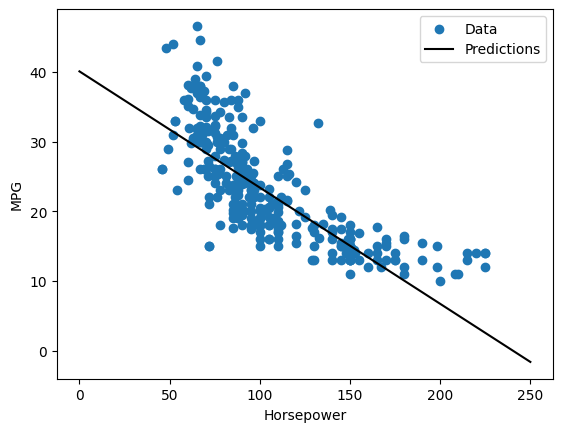

In [113]:
def plot_horsepower(x,y):
  plt.scatter(train_features['Horsepower'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Horsepower')
  plt.ylabel('MPG')
  plt.legend()

plot_horsepower(x, y)

## Linear regression with multiple inputs

Creating a two-step Keras Sequential model again with the first layer being **normalizer(tf.keras.layers.Normalization(axis=1))** defined earlier and adapted to the whole dataset

In [114]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

When [Model.predict](https://) is called on a batch of inputs, it produces **units=1** outputs for each example.

In [115]:
linear_model.predict(train_features[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step


array([[-2.538],
       [-0.601],
       [ 1.189],
       [-0.931],
       [ 1.13 ],
       [ 0.207],
       [ 0.962],
       [ 0.094],
       [-0.815],
       [ 0.035]], dtype=float32)

In [116]:
linear_model.layers[1].kernel

<Variable path=sequential_7/dense_11/kernel, shape=(9, 1), dtype=float32, value=[[ 0.347]
 [ 0.498]
 [ 0.469]
 [ 0.392]
 [ 0.135]
 [ 0.768]
 [-0.309]
 [ 0.462]
 [-0.552]]>

Configure the model with Keras [Model.compile](https://) and train with [Model.fit](https://) for 100 epochs.

In [117]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)

# %%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    #Supress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split=0.2
)

Using all the inputs in this regression model achieves a much lower training and validation error than the **horsepower_model**, which had one input:

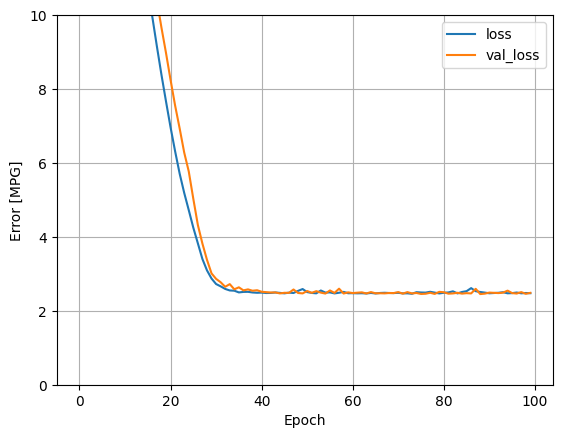

In [118]:
plot_loss(history)

In [119]:
# Collecting the results on the test set for later
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0
)

## Regression with a deep neural network(DNN)
We will implement single-input and multiple-input DNN models.

The code is basically the same except the model is expanded to include some "hidden" non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:



*   The normalization layer, as before (with **horsepower_normalizer** for a  
    single-input model and **normalizer** for a multiple-input model).
*   Two hidden, non-linear, **Dense** layers with the ReLU (relu) activation
    function nonlinearity.
*   A linear Dense single-output layer.
Both models will use the same training procedure, so the **compile** method is included in the **build_and_compile_model** function below.

In [120]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

# Regression using a DNN and a single input.

Creating a DNN model with only 'Horsepower' as input and horsepower_normalizer(defined earlier) as the normalization layer:

In [121]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

This model has quite a few more trainable parameters than the linear  models:

In [122]:
dnn_horsepower_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_5 (Normalization) │ (None, 1)              │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,356 (17.02 KB)

 Trainable params: 4,353 (17.00 KB)

 Non-trainable params: 3 (16.00 B)

Training the model with keras [Model.fit](https://).

In [123]:
history = dnn_horsepower_model.fit(
    train_features['Horsepower'],
    train_labels,
    validation_split=0.2,
    verbose=0,
    epochs=100
)

This model does better than the linear single-input **horsepower_model**:

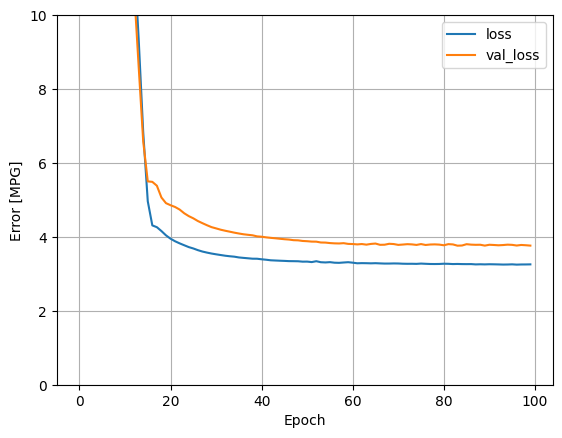

In [124]:
plot_loss(history)

Plotting the predictions as a function of **'Horsepower'**, the model takes advantage of the nonlinearity provided by the hidden layers:

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


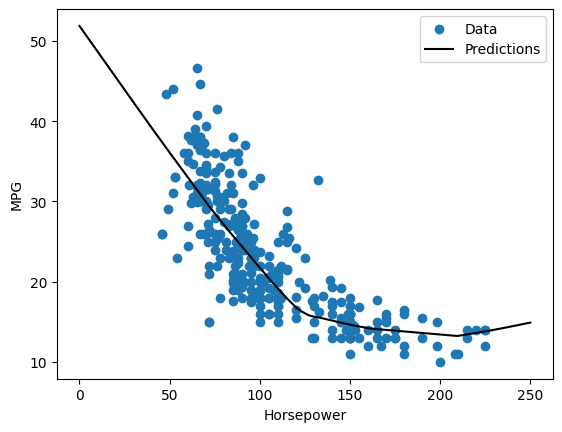

In [125]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

plot_horsepower(x, y)

Collecting the results on the test set for later

In [126]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    test_features['Horsepower'], test_labels,
    verbose=0)

## Regression using a DNN and multiple inputs

The model's performance slightly improves on the validation dataset.

In [127]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_4 (Normalization) │ (10, 9)                │            19 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19 (80.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 19 (80.00 B)

CPU times: user 14.8 s, sys: 641 ms, total: 15.5 s
Wall time: 18.4 s


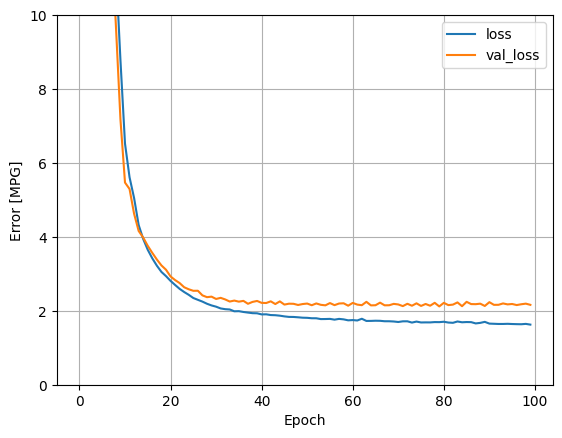

In [128]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

plot_loss(history)

  Collecting the results on the test set

In [129]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

## Performance

Since all models have benn trained, let's review their test set performance:

In [130]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.647662
linear_model,2.518768
dnn_horsepower_model,2.948587
dnn_model,1.714899


These results must match the validation error observed during training.

## Making predictions
Make predictions with the dnn_model on the test set using Keras [Model.predict](https://) and review the loss.

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


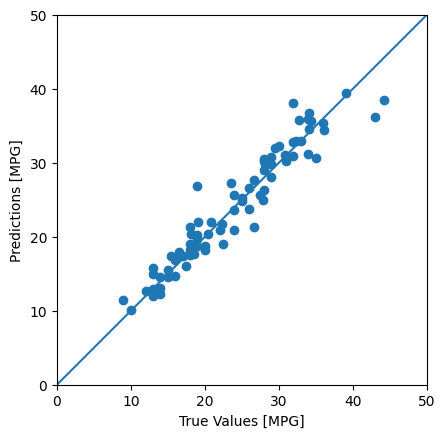

In [131]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

The model predicts reasonably well.

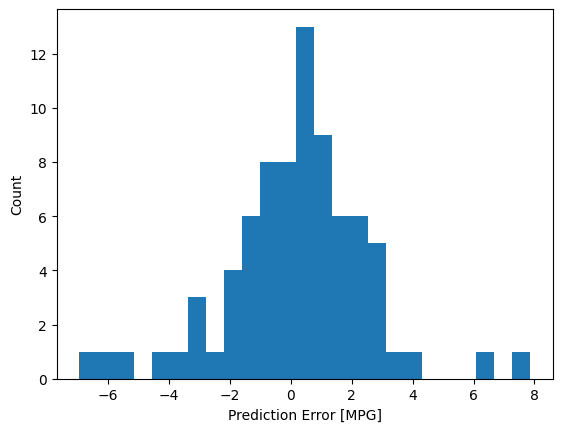

In [132]:
# Checking the error distribution
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

Saving the model

In [133]:
dnn_model.save('dnn_model.keras')

Reloading the model, it gives identical output.

In [134]:
reloaded = tf.keras.models.load_model('dnn_model.keras')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [135]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]']).T

,Mean absolute error [MPG]
horsepower_model,3.647662
linear_model,2.518768
dnn_horsepower_model,2.948587
dnn_model,1.714899
reloaded,1.714899


## Conclusion

This notebook introduced a few techniques to handle a regression problem. Here are a few more tips that may help:

*   Mean squared error (MSE) (tf.keras.losses.MeanSquaredError [link text]    
    (https://)) and mean absolute error (MAE) (tf.keras.losses.MeanAbsoluteError [link text](https://)) are common loss functions used for regression problems. MAE is less sensitive to outliers. Different loss functions are used for classification problems.

*   Similarly, evaluation metrics used for regression differ from
    classification.

*   When numeric input data features have values with different ranges, each  
    feature should be scaled independently to the same range.

*   Overfitting is a common problem for DNN models, though it wasn't a problem
    for this tutorial. Visit the [Overfit and underfit](https://) tutorial for more help with this.